In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [180]:
class grid():
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y
        self.x_points = np.empty(0)
        self.y_points = np.empty(0)
        self.x_max = 1000
        self.y_max = 1000
        self.grid = {}  
        self.elevation = {}
        self.elevation_intermediate = []
        self.grid_customers = {}  
        self.n_customers = 0      
        self.customer_points = {}
        self.customer_points_intermediate = {}
        self.depot = None
        self.d_ij_indices = {} 
        self.n_intermediate = 0
        self.d_ij = None          # distances among customers - interface output for the optimization model
        self.d_ij_extended = None
        self.output_matrix = None
        self.output_matrix_extended = None
        self.tw_a = None
        self.tw_b = None
        self.load = None
        self.servicetime = 5 # minutes
        
        self.create_grid()
        self.grid_dict()
        
    def create_grid(self):
        delta_x = 20
        delta_y = 20
        np.random.seed(9)
        self.x_points = np.linspace(0, self.x_max, self.n_x+1) + np.random.randint(-delta_x, delta_x, self.n_x+1)
        self.y_points = np.linspace(0, self.y_max, self.n_y+1) + np.random.randint(-delta_y, delta_y, self.n_y+1)
        self.x_points[0] = 0; self.x_points[-1] = self.x_max
        self.y_points[0] = 0; self.y_points[-1] = self.y_max
        self.x_points.sort()
        self.y_points.sort()
        
    def grid_dict(self):
        for i in range(self.n_x+1):
            for j in range(self.n_y+1):
                self.grid[(i,j)] = (self.x_points[i], self.y_points[j])
                self.elevation[(i,j)] = 30*np.random.random()
        return self.grid
    
    def time_windows(self, tp='random', min_t=50, max_t=200, k_separation = 0.05, k_overlapped = 0.5):
        tw_a = np.zeros(1, dtype=int); tw_b = np.zeros(1, dtype=int)
        if tp == 'random':
            delta_lower = min_t/2
            delta_upper = delta_lower
            tw_center = np.random.randint(min_t+delta_lower, max_t-delta_upper, self.n_customers)
            self.tw_a = np.append(tw_a, tw_center - np.random.randint(0, delta_lower, self.n_customers))
            self.tw_b = np.append(tw_b, tw_center + np.random.randint(0, delta_upper, self.n_customers))
            return self.tw_a, self.tw_b
        if tp == 'separated':
            delta_tw = (max_t - min_t)/self.n_customers
            self.tw_a = np.append(tw_a, np.array([min_t + (i - k_separation)*delta_tw for i in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + (i + k_separation)*delta_tw for i in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
        if tp == 'overlapped':
            tw_c = (max_t - min_t)/2
            tw_interval = 0.5*k_overlapped*tw_c # half base interval (centered halfway between max_t and min_t)
            delta_interval = np.random.randint(0, tw_interval, self.n_customers)
            self.tw_a = np.append(tw_a, np.array([min_t + tw_c - t for t in sorted(delta_interval)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + tw_c + t for t in sorted(delta_interval)]) )
            # np.random.shuffle(tw_a); np.random.shuffle(tw_b)
            return self.tw_a, self.tw_b
        if tp == 'single':
            self.tw_a = np.append(tw_a, np.array([min_t for _ in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([max_t for _ in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
    
    def payload(self, min_p=5, max_p=30):
        self.load = np.append(np.zeros(1), np.random.randint(min_p, max_p, self.n_customers))
    
    def plot_grid(self):
        for i in range(self.n_x+1):
            plt.plot([self.x_points[i], self.x_points[i]], [0, self.y_max], color='gray')
        for j in range(self.n_y+1):
            plt.plot([0, self.x_max], [self.y_points[j], self.y_points[j]], color='gray')
        
    def customers(self, n_customers):
        self.n_customers = n_customers
        random.seed(9); 
        customer_points = random.sample(list(self.grid.items()), n_customers)
        self.customer_points = {k:v for k, v in customer_points}
        return self.customer_points
        
    def plot_customer_points(self):
        k = list(self.customer_points.values())
        self.plot_grid()
        for i in range(self.n_customers):
            plt.scatter(k[i][0], k[i][1])
        
    def plot_customer_number(self):
        k = list(self.customer_points.keys())
        a=np.empty((self.n_x+1,self.n_y+1))
        for x in range(self.n_x+1):
            for y in range(self.n_y+1):
                a[x,y]=self.elevation[(x,y)]
        #self.plot_grid()
        plt.imshow(a,alpha=0.3, cmap='gnuplot2_r', interpolation='bicubic',origin='lower') 
        count=0 
        for i in range(self.n_customers):
            count+=1
            plt.text(k[i][0], k[i][1], f"{count}", fontsize=12)
        
    def customers_paths(self, depot):
        ## # depot must be an appropriate tuple of coordinate indices of the grid: ex (12, 15): (12th pos. on x - 15th pos. on y)
        self.depot = depot
        nodes = list(self.customer_points.keys())  # we work with grid indices instead of coordinates
        nodes.insert(0, depot)
        print(nodes)
        
        # we insert an intermediate point only if the two points are not on the same horizontal or vertical line 
        # a variation could be to use a point internal to the horizontal/vertical edge if the the latter is longer than 1 grid point
        self.n_intermediate = 0    
        for i in range(self.n_customers+1):
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                dy_index = nodes[i][1] - nodes[j][1]
                if (dx_index != 0 and dy_index != 0):
                    self.n_intermediate += 1
        self.n_intermediate //= 2
        print('n_intermediate', self.n_intermediate)  
        
        self.d_ij = np.zeros((self.n_customers+1, self.n_customers+1))
        self.d_ij_extended = np.zeros((self.n_customers+1+self.n_intermediate, self.n_customers+1+self.n_intermediate))
        
        self.customer_points_intermediate = self.customer_points.copy()
        int_node = 0
        for i in range(self.n_customers+1):
            print('node:', i, nodes[i])
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                dy_index = nodes[i][1] - nodes[j][1]
                node_int = (nodes[i][0] - dx_index, nodes[i][1])
                self.d_ij_indices[(i,j)] = (nodes[i], node_int, nodes[j])
                # self.d_ij_indices[(i,j)] = ((nodes[i][0], nodes[i][1]), (nodes[i][0]-dx_index, nodes[i][1]), (nodes[j][0], nodes[j][1]))
                print(self.d_ij_indices[(i,j)])
                
                dx = abs(self.grid[node_int][0] - self.grid[nodes[i]][0])
                dy = abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                self.d_ij[i,j] = dx + dy
                self.d_ij_extended[i,j] = dx + dy 
                
                if (dx_index != 0 and dy_index != 0) and (self.grid[node_int][1] <= self.grid[nodes[j]][1]):
                    self.customer_points_intermediate[node_int] = self.grid[node_int]
                    int_node += 1
                    self.d_ij_extended[i,self.n_customers+int_node] = abs(self.grid[node_int][0] - self.grid[nodes[i]][0])   
                    self.d_ij_extended[self.n_customers+int_node,i] = self.d_ij_extended[i,self.n_customers+int_node]#abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                    self.d_ij_extended[j,self.n_customers+int_node] = abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                    self.d_ij_extended[self.n_customers+int_node,j] = self.d_ij_extended[j,self.n_customers+int_node]
                    self.elevation_intermediate.append(self.elevation[node_int])
                    
        print('d_ij_indices\n', self.d_ij_indices)
        
        return self.d_ij
    
    def create_csv(self):
        elevation = np.zeros(self.n_customers)
        # elevation_intermediate = np.zeros(self.n_customers+self.n_intermediate)
        
        for i, k in enumerate(self.customer_points.keys()):
            elevation[i] = self.elevation[k]
        # for i, k in enumerate(self.customer_points_intermediate.keys()):
        #     elevation_intermediate[i] = self.elevation[k]
         
        elevation = np.append(self.elevation[self.depot], elevation)
        elevation_intermediate = np.append(elevation, self.elevation_intermediate)
        
        service_time = np.append(np.zeros(1), np.array([self.servicetime for _ in range(self.n_customers)]) )
        service_time_intermediate = np.append(service_time, np.nan*np.ones(self.n_intermediate))
        
        x = np.append(self.grid[self.depot][0], np.array([v[0] for v in self.customer_points.values()]) )
        y = np.append(self.grid[self.depot][1], np.array([v[1] for v in self.customer_points.values()]) )
        x_intermediate = np.append(x, np.zeros(self.n_intermediate))
        y_intermediate = np.append(y, np.zeros(self.n_intermediate))
        
        index = np.linspace(0,self.n_customers,self.n_customers+1)
        index_intermediate = np.linspace(0,self.n_customers+self.n_intermediate,self.n_customers+self.n_intermediate+1)
        
        self.output_matrix = np.c_[index, x, y, elevation, self.load, self.tw_a, self.tw_b, service_time, self.d_ij/1000]
        
        load_intermediate = np.append(self.load.copy(), -np.ones(self.n_intermediate))
        tw_a_intermediate = np.append(self.tw_a.copy(), np.zeros(self.n_intermediate))
        tw_b_intermediate = np.append(self.tw_b.copy(), np.zeros(self.n_intermediate))
        service_time_intermediate = np.append(service_time.copy(), np.zeros(self.n_intermediate))
        self.output_matrix_extended = np.c_[index_intermediate, x_intermediate, y_intermediate, elevation_intermediate, load_intermediate, tw_a_intermediate, 
                                            tw_b_intermediate, service_time_intermediate, self.d_ij_extended/1000]
                                            
        header = ',x,y,elevation,demand,tw a,tw b,s'
        for i in range(self.n_customers+1):
            header += ','+str(i)
           
        np.savetxt('generated_grid_1.csv', self.output_matrix, delimiter=',', header=header, comments='')
        
        header = ',x,y,elevation,demand,tw a,tw b,s'
        for i in range(self.n_customers+1+self.n_intermediate):
            header += ','+str(i)
        
        np.savetxt('generated_grid_1_extended.csv', self.output_matrix_extended, delimiter=',', header=header, comments='')
                                            
        return self.output_matrix

In [181]:
G = grid(10, 10)
print(G.grid[(1,3)])
print(G.grid[(5,3)])

(102.0, 302.0)
(513.0, 302.0)


In [182]:
np.linspace(0,21,22)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21.])

In [183]:
np.append(np.zeros(1), np.random.randint(5, 10, 5))

array([0., 6., 7., 6., 7., 8.])

In [184]:
a,b = G.time_windows(tp='single', min_t= 50, max_t=400)


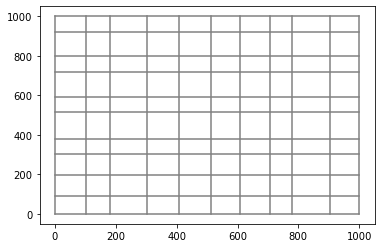

In [185]:
G.plot_grid()

In [186]:
print(np.round(G.x_points, 2))
print(np.round(G.y_points, 2))
print(G.n_x)

[   0.  102.  181.  302.  407.  513.  609.  708.  780.  904. 1000.]
[   0.   92.  198.  302.  381.  515.  591.  717.  799.  918. 1000.]
10


In [187]:
print(G.elevation[(0,0)])
print(G.elevation[(3,5)])

22.950551869092376
10.627392858525313


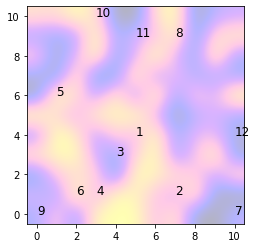

In [188]:
G.customers(12)
# for i in range(2,5): print(i)
G.plot_customer_number()

In [189]:
for v in G.customer_points.items():
    print(v)

((5, 4), (513.0, 381.0))
((7, 1), (708.0, 92.0))
((4, 3), (407.0, 302.0))
((3, 1), (302.0, 92.0))
((1, 6), (102.0, 591.0))
((2, 1), (181.0, 92.0))
((10, 0), (1000.0, 0.0))
((7, 9), (708.0, 918.0))
((0, 0), (0.0, 0.0))
((3, 10), (302.0, 1000.0))
((5, 9), (513.0, 918.0))
((10, 4), (1000.0, 381.0))


In [29]:
for v in G.customer_points_intermediate.items():
    print(v)

In [30]:
for v in G.customer_points_intermediate.keys():
    print(v)

In [31]:
for v in G.customer_points_intermediate.keys():
    print(G.elevation[v])

In [32]:
# G.customer_points
print(G.n_intermediate)
print(len(G.customer_points_intermediate))

0
0


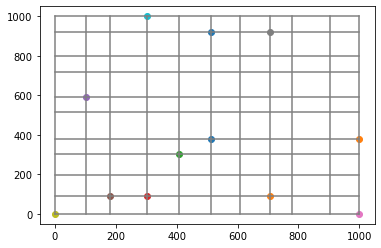

In [33]:
G.plot_customer_points()

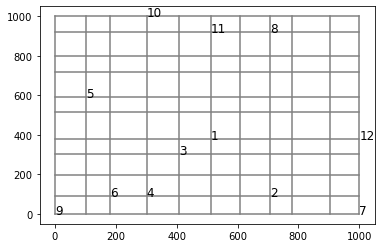

In [34]:
G.plot_customer_number()

In [35]:
# print(G.elevation.keys())
# print(G.d_ij_extended.keys())
print(np.shape(G.d_ij_extended))

()


In [36]:
G.customers_paths((0,0))

[(0, 0), (5, 4), (7, 1), (4, 3), (3, 1), (1, 6), (2, 1), (10, 0), (7, 9), (0, 0), (3, 10), (5, 9), (10, 4)]
n_intermediate 66
node: 0 (0, 0)
((0, 0), (0, 0), (0, 0))
((0, 0), (5, 0), (5, 4))
((0, 0), (7, 0), (7, 1))
((0, 0), (4, 0), (4, 3))
((0, 0), (3, 0), (3, 1))
((0, 0), (1, 0), (1, 6))
((0, 0), (2, 0), (2, 1))
((0, 0), (10, 0), (10, 0))
((0, 0), (7, 0), (7, 9))
((0, 0), (0, 0), (0, 0))
((0, 0), (3, 0), (3, 10))
((0, 0), (5, 0), (5, 9))
((0, 0), (10, 0), (10, 4))
node: 1 (5, 4)
((5, 4), (0, 4), (0, 0))
((5, 4), (5, 4), (5, 4))
((5, 4), (7, 4), (7, 1))
((5, 4), (4, 4), (4, 3))
((5, 4), (3, 4), (3, 1))
((5, 4), (1, 4), (1, 6))
((5, 4), (2, 4), (2, 1))
((5, 4), (10, 4), (10, 0))
((5, 4), (7, 4), (7, 9))
((5, 4), (0, 4), (0, 0))
((5, 4), (3, 4), (3, 10))
((5, 4), (5, 4), (5, 9))
((5, 4), (10, 4), (10, 4))
node: 2 (7, 1)
((7, 1), (0, 1), (0, 0))
((7, 1), (5, 1), (5, 4))
((7, 1), (7, 1), (7, 1))
((7, 1), (4, 1), (4, 3))
((7, 1), (3, 1), (3, 1))
((7, 1), (1, 1), (1, 6))
((7, 1), (2, 1), (2

array([[   0.,  894.,  800.,  709.,  394.,  693.,  273., 1000., 1626.,
           0., 1302., 1431., 1381.],
       [ 894.,    0.,  484.,  185.,  500.,  621.,  621.,  868.,  732.,
         894.,  830.,  537.,  487.],
       [ 800.,  484.,    0.,  511.,  406., 1105.,  527.,  384.,  826.,
         800., 1314., 1021.,  581.],
       [ 709.,  185.,  511.,    0.,  315.,  594.,  436.,  895.,  917.,
         709.,  803.,  722.,  672.],
       [ 394.,  500.,  406.,  315.,    0.,  699.,  121.,  790., 1232.,
         394.,  908., 1037.,  987.],
       [ 693.,  621., 1105.,  594.,  699.,    0.,  578., 1489.,  933.,
         693.,  609.,  738., 1108.],
       [ 273.,  621.,  527.,  436.,  121.,  578.,    0.,  911., 1353.,
         273., 1029., 1158., 1108.],
       [1000.,  868.,  384.,  895.,  790., 1489.,  911.,    0., 1210.,
        1000., 1698., 1405.,  381.],
       [1626.,  732.,  826.,  917., 1232.,  933., 1353., 1210.,    0.,
        1626.,  488.,  195.,  829.],
       [   0.,  894.,  800.,

In [37]:
G.customer_points_intermediate

{(5, 4): (513.0, 381.0),
 (7, 1): (708.0, 92.0),
 (4, 3): (407.0, 302.0),
 (3, 1): (302.0, 92.0),
 (1, 6): (102.0, 591.0),
 (2, 1): (181.0, 92.0),
 (10, 0): (1000.0, 0.0),
 (7, 9): (708.0, 918.0),
 (0, 0): (0.0, 0.0),
 (3, 10): (302.0, 1000.0),
 (5, 9): (513.0, 918.0),
 (10, 4): (1000.0, 381.0),
 (5, 0): (513.0, 0.0),
 (7, 0): (708.0, 0.0),
 (4, 0): (407.0, 0.0),
 (3, 0): (302.0, 0.0),
 (1, 0): (102.0, 0.0),
 (2, 0): (181.0, 0.0),
 (1, 4): (102.0, 381.0),
 (7, 4): (708.0, 381.0),
 (3, 4): (302.0, 381.0),
 (5, 1): (513.0, 92.0),
 (4, 1): (407.0, 92.0),
 (1, 1): (102.0, 92.0),
 (10, 1): (1000.0, 92.0),
 (5, 3): (513.0, 302.0),
 (1, 3): (102.0, 302.0),
 (7, 3): (708.0, 302.0),
 (3, 3): (302.0, 302.0),
 (10, 3): (1000.0, 302.0),
 (7, 6): (708.0, 591.0),
 (3, 6): (302.0, 591.0),
 (5, 6): (513.0, 591.0),
 (3, 9): (302.0, 918.0)}

In [38]:
G.customer_points.keys()

dict_keys([(5, 4), (7, 1), (4, 3), (3, 1), (1, 6), (2, 1), (10, 0), (7, 9), (0, 0), (3, 10), (5, 9), (10, 4)])

In [39]:
G.customer_points_intermediate.keys()

dict_keys([(5, 4), (7, 1), (4, 3), (3, 1), (1, 6), (2, 1), (10, 0), (7, 9), (0, 0), (3, 10), (5, 9), (10, 4), (5, 0), (7, 0), (4, 0), (3, 0), (1, 0), (2, 0), (1, 4), (7, 4), (3, 4), (5, 1), (4, 1), (1, 1), (10, 1), (5, 3), (1, 3), (7, 3), (3, 3), (10, 3), (7, 6), (3, 6), (5, 6), (3, 9)])

In [40]:
G.d_ij_extended

array([[  0., 894., 800., ...,   0.,   0.,   0.],
       [894.,   0., 484., ...,   0.,   0.,   0.],
       [800., 484.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [41]:
G.customer_points_intermediate.keys()

dict_keys([(5, 4), (7, 1), (4, 3), (3, 1), (1, 6), (2, 1), (10, 0), (7, 9), (0, 0), (3, 10), (5, 9), (10, 4), (5, 0), (7, 0), (4, 0), (3, 0), (1, 0), (2, 0), (1, 4), (7, 4), (3, 4), (5, 1), (4, 1), (1, 1), (10, 1), (5, 3), (1, 3), (7, 3), (3, 3), (10, 3), (7, 6), (3, 6), (5, 6), (3, 9)])

In [42]:
elevation = []
for i, k in enumerate(G.customer_points_intermediate.keys()):
            print(G.elevation[k])

4.403646954327418
28.181124087540663
21.886952164995595
3.8506881457728204
13.046661949816729
11.783433862819336
7.862311838272717
21.786169703420832
22.950551869092376
27.097991824068124
17.047457586933536
28.839355597596654
0.24435134903642797
24.34243621696351
24.127260970206237
5.323810539232055
17.45254171045143
27.892136802004448
2.2353385679873927
27.008987168791094
26.103570095688788
10.111907363258112
0.13691547008878424
23.829523378523575
9.004135629670936
4.047832333139471
17.407806369714876
29.416293680713995
19.06718495886738
8.496763784174494
21.943447339402454
1.0434647500755723
16.703254387997646
2.136591011685749


In [43]:
print(G.n_intermediate)
print(G.n_customers+G.n_intermediate)
print(len(G.customer_points_intermediate))

66
78
34


In [44]:
for i, k in enumerate(G.customer_points_intermediate.keys()):
            print(G.elevation[k])

4.403646954327418
28.181124087540663
21.886952164995595
3.8506881457728204
13.046661949816729
11.783433862819336
7.862311838272717
21.786169703420832
22.950551869092376
27.097991824068124
17.047457586933536
28.839355597596654
0.24435134903642797
24.34243621696351
24.127260970206237
5.323810539232055
17.45254171045143
27.892136802004448
2.2353385679873927
27.008987168791094
26.103570095688788
10.111907363258112
0.13691547008878424
23.829523378523575
9.004135629670936
4.047832333139471
17.407806369714876
29.416293680713995
19.06718495886738
8.496763784174494
21.943447339402454
1.0434647500755723
16.703254387997646
2.136591011685749


In [45]:
# G.d_ij_indices

In [46]:
# G.d_ij

In [47]:
# print(G.grid_dict()[(0,0)])
# print(G.grid_dict()[(1,7)])
# print(G.grid_dict()[(16,23)])
# print(G.grid_dict()[(19,0)])

In [31]:
# G.customer_points

In [32]:
# for k in G.customer_points.keys():
#     print(k, ' elevation: ', G.elevation[k])

In [ ]:
ta, tb = G.time_windows()
print(ta)
print(tb)

In [ ]:
G.payload()
print(len(G.elevation_intermediate))

In [ ]:
out = G.create_csv()

In [ ]:
# G1 = grid(10, 10)

In [ ]:
# G1.customers(20)

In [ ]:
# G1.plot_customer_points()

In [ ]:
# G1.customers_paths((0,0))

In [ ]:
# G1.time_windows()

In [ ]:
# G1.payload()

In [ ]:
# G1.create_csv()